In [1]:
from qiskit_machine_learning.datasets import *
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [2]:
#constants
n = 4
RANDOM_STATE = 42
#LR = 1e-3
class_labels = ['yes', 'no']

# 1.Normalize The Data

In [3]:
def normalizeData(DATA_PATH = "../data/processed/heartattackdata.csv"):
    """
    Normalizes the data
    """
    # Reads the data
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data, random_state=RANDOM_STATE)
    X, Y = data[['sex', 'cp', 'exang', 'oldpeak']].values, data['num'].values
    # normalize the data
    X = normalize(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

In [4]:
X_train, X_test, Y_train, Y_test = normalizeData()

In [5]:
X_train.shape

(205, 4)

In [6]:
X_test.shape

(88, 4)

# 2. Set a Quantum Circuit with 4 Qubits
Use ZZFeatureMap to do Feature map
Use RealAmplitudes as Parameterized Circuit

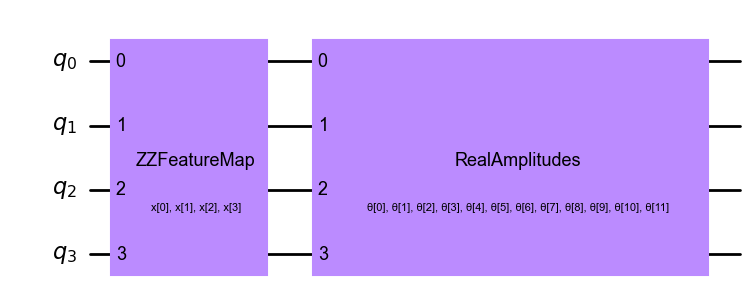

In [13]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=2)
circuit = feature_map.compose(var_form)
circuit.draw(output='mpl', filename="../output/figures/overallcircuit.png")

# 3. Data Mapping

In [8]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [9]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [10]:
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
    class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

# 4. Classify the Sample Data

In [11]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
        probs = []
    for qc in qc_list:
        #counts = qc.to_counts()
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

# 5. Calculate The Cost(MSE)

In [12]:
def mse_cost(probs, expected_label):
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

In [13]:
cost_list = []
def cost_function(X, Y, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    for label in Y:
        if label == 0:
            training_labels += [class_labels[0]]
        elif label == 1:
            training_labels += [class_labels[1]]
    probs = classify(training_samples, params, class_labels)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += mse_cost(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    cost_list.append(cost)
    return cost

# 6. Optimize the Parameters

## 6.1 ADAM

In [14]:
cost_list = []
optimizer = ADAM(maxiter=1000)

# define objective function for training
objective_function = lambda params: cost_function(X_train, Y_train, class_labels, params, print_value=True)
# randomly initialize the parameters
np.random.seed(RANDOM_STATE)
init_params = 2*np.pi*np.random.rand(n*(1)*2)

# train classifier
#opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
#opt_params, value, _ = optimizer.minimize(fun=objective_function, x0=init_params)
startTime = time.perf_counter()
result = optimizer.minimize(fun=objective_function, x0=init_params)
endTime = time.perf_counter()
print("Total Running Time is {} S".format(endTime-startTime))
# print results
print()
print('opt_params:',result.x)
print('opt_value:',result.fun)
print('Total Function Evaluation Time: ',result.nfev)
print('Total Gradient Evaluation Time: ',result.njev)
# print('opt_params:', opt_params)
# print('opt_value: ', value)

0.2878
0.2878
0.2878
0.2878
0.2878
0.2878
0.2878
0.2878
0.2878
0.2875
0.2875
0.2875
0.2875
0.2875
0.2875
0.2875
0.2875
0.2875
0.2872
0.2872
0.2872
0.2872
0.2872
0.2872
0.2872
0.2872
0.2872
0.2869
0.2869
0.2869
0.2869
0.2869
0.2869
0.2869
0.2869
0.2869
0.2866
0.2866
0.2866
0.2866
0.2866
0.2866
0.2866
0.2866
0.2866
0.2863
0.2863
0.2863
0.2863
0.2863
0.2863
0.2863
0.2863
0.2863
0.2860
0.2860
0.2860
0.2860
0.2860
0.2860
0.2860
0.2860
0.2860
0.2857
0.2857
0.2857
0.2857
0.2857
0.2857
0.2857
0.2857
0.2857
0.2854
0.2854
0.2854
0.2854
0.2854
0.2854
0.2854
0.2854
0.2854
0.2851
0.2851
0.2851
0.2851
0.2851
0.2851
0.2851
0.2851
0.2851
0.2848
0.2848
0.2848
0.2848
0.2848
0.2848
0.2848
0.2848
0.2848
0.2845
0.2845
0.2845
0.2845
0.2845
0.2845
0.2845
0.2845
0.2845
0.2842
0.2842
0.2842
0.2842
0.2842
0.2842
0.2842
0.2842
0.2842
0.2839
0.2839
0.2839
0.2839
0.2839
0.2839
0.2839
0.2839
0.2839
0.2836
0.2836
0.2836
0.2836
0.2836
0.2836
0.2836
0.2836
0.2836
0.2833
0.2833
0.2833
0.2833
0.2833
0.2833
0.2833
0.2833

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
plt.plot(range(0,901,1), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("ADAM Cost value against steps")
plt.show()
fig.savefig('../output/figures/ADAMcostVSsteps.png')

In [ ]:
def test_model(X, Y, class_labels, params):
    accuracy = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = classify(training_samples, params, class_labels)
    for i, prob in enumerate(probs):
        if (prob.get('yes') >= prob.get('no')) and (Y_test[i] == 0):
            accuracy += 1
        elif (prob.get('no') >= prob.get('yes')) and (Y_test[i] == 1):
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))

In [ ]:
test_model(X_test, Y_test, class_labels, result.x)